In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [12]:
count_table = pd.read_csv("new_data.csv", sep=";", index_col=0)
pheno_data = pd.read_csv("pheno_data.csv", sep=";", index_col=0)

In [3]:
print(count_table.head())
print(pheno_data.head())

                          CTR1_24h  CTR2_24h  CTR3_24h  CTR4_24h  EV1_24h  \
ENSG00000288531                  0         3         0         0        0   
ENSG00000230368|FAM41C           3         6         2         4        3   
ENSG00000234711|TUBB8P11         0         0         0         0        0   
ENSG00000283040                  0         0         0         0        0   
ENSG00000188290|HES4            25        42        33        20       17   

                          EV2_24h  EV3_24h  EV4_24h  
ENSG00000288531                 0        0        0  
ENSG00000230368|FAM41C          4        2        5  
ENSG00000234711|TUBB8P11        0        0        0  
ENSG00000283040                 0        0        0  
ENSG00000188290|HES4           39       24       47  
            sample condition
CTR1_24h  CTR1_24h       CTR
CTR2_24h  CTR2_24h       CTR
CTR3_24h  CTR3_24h       CTR
CTR4_24h  CTR4_24h       CTR
EV1_24h    EV1_24h        EV


In [4]:
count_table = count_table.T
pheno_data = pheno_data.loc[count_table.index]
count_log = np.log1p(count_table)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(count_log)
percentVar = pca.explained_variance_ratio_ * 100

pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2"], index=count_table.index)
pca_df["condition"] = pheno_data["condition"].values

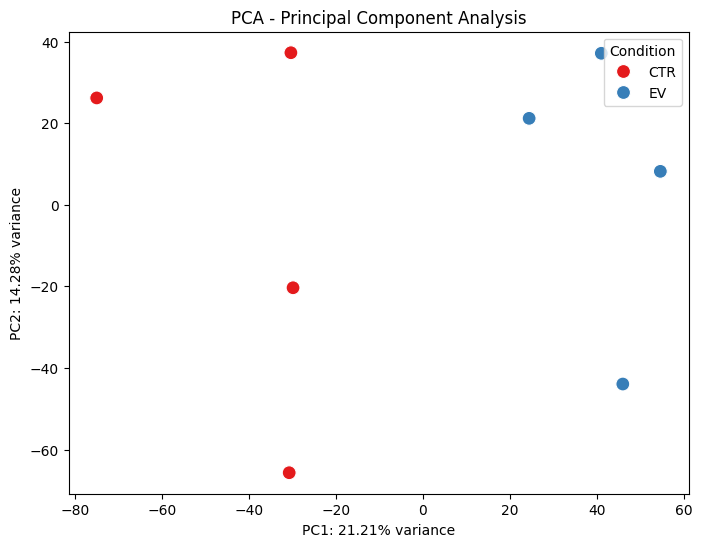

In [5]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="condition", s=100, palette="Set1")
plt.xlabel(f"PC1: {percentVar[0]:.2f}% variance")
plt.ylabel(f"PC2: {percentVar[1]:.2f}% variance")
plt.title("PCA - Principal Component Analysis")
plt.legend(title="Condition")
plt.show()

## Punkt 2

In [6]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist
from sklearn.preprocessing import StandardScaler

c:\users\kacpe\pycharmprojects\pf\venv\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1000x600 with 0 Axes>

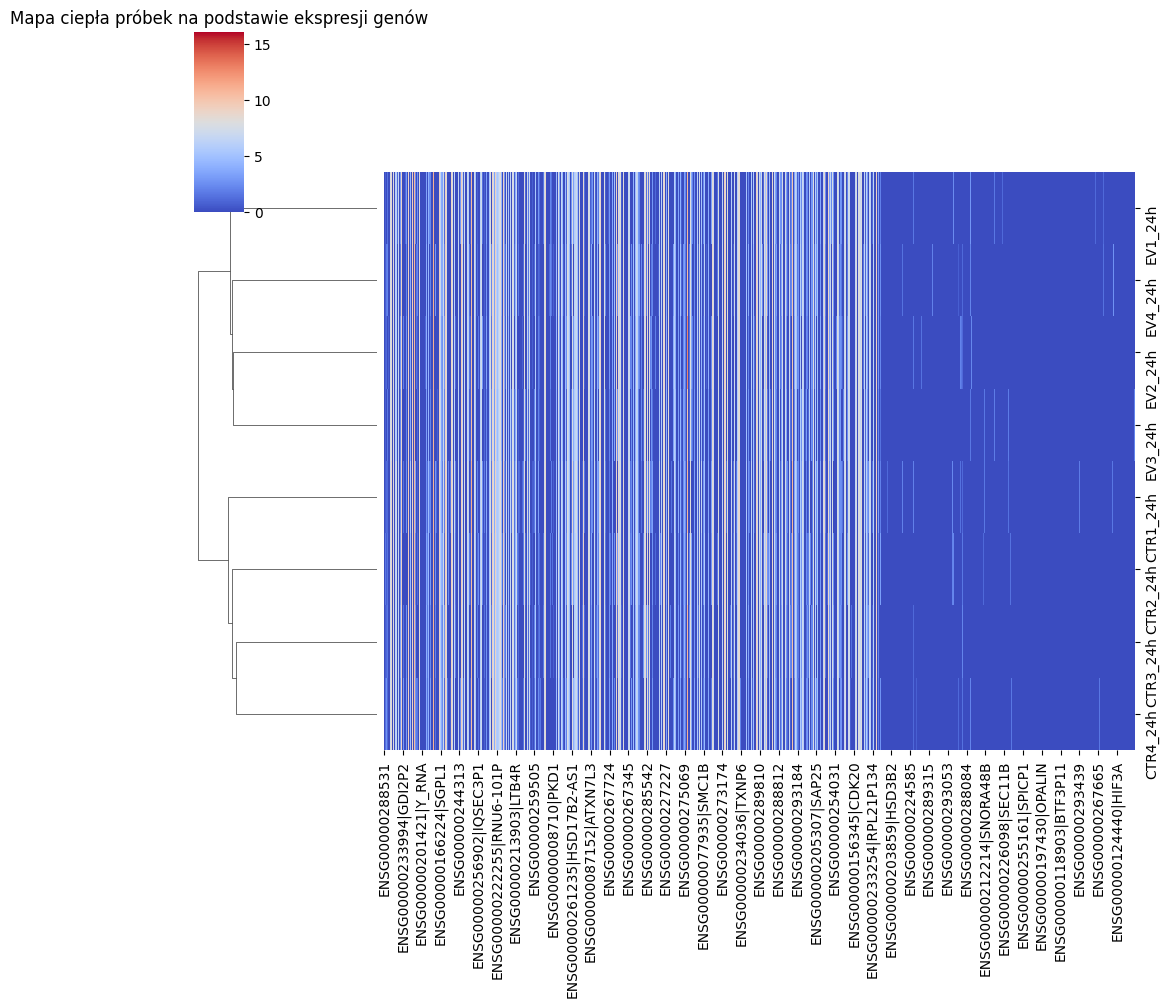

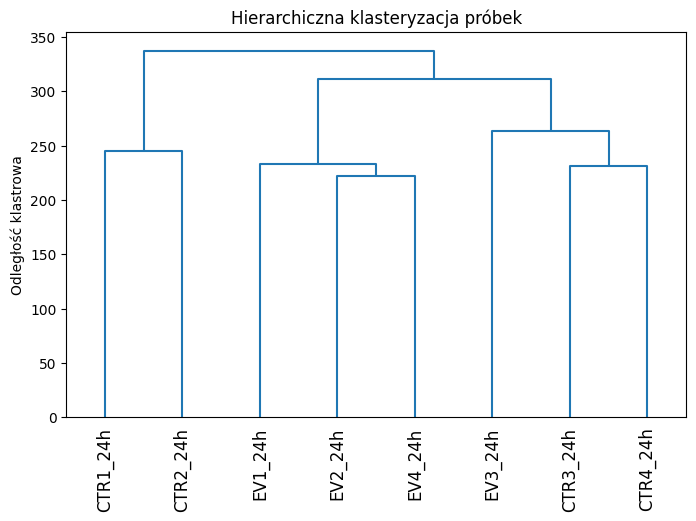

In [7]:
scaler = StandardScaler()
count_scaled = scaler.fit_transform(count_log)

distance_matrix = pdist(count_scaled, metric="euclidean")  # Odległość euklidesowa
linkage_matrix = linkage(distance_matrix, method="ward")  # Metoda Ward’a

plt.figure(figsize=(10, 6))
sns.clustermap(count_log, method="ward", cmap="coolwarm", row_cluster=True, col_cluster=False)
plt.title("Mapa ciepła próbek na podstawie ekspresji genów")
plt.show()

# **Drzewo klasteryzacji**
plt.figure(figsize=(8, 5))
dendrogram(linkage_matrix, labels=count_log.index, leaf_rotation=90, color_threshold=0.5*max(linkage_matrix[:,2]))
plt.title("Hierarchiczna klasteryzacja próbek")
plt.ylabel("Odległość klastrowa")
plt.show()

In [8]:
de_results = pd.read_csv("differential_expression_results.csv", index_col=0)
print(de_results.head())

de_results['-log10(padj)'] = -np.log10(de_results['padj'])

# Kolorowanie punktów: czerwona dla genów istotnych, czarna dla reszty
de_results['color'] = np.where(de_results['padj'] < 0.001, 'red', 'black')

                           baseMean  log2FoldChange     lfcSE      stat  \
ENSG00000230368|FAM41C     3.559051       -0.058512  0.935919 -0.062519   
ENSG00000188290|HES4      30.338049        0.130705  0.386469  0.338204   
ENSG00000187608|ISG15    379.851664        0.069571  0.138140  0.503628   
ENSG00000187583|PLEKHN1   43.919219       -0.231546  0.390067 -0.593607   
ENSG00000187642|PERM1      7.706554       -0.321302  0.911873 -0.352354   

                           pvalue      padj  
ENSG00000230368|FAM41C   0.950150  0.975114  
ENSG00000188290|HES4     0.735210  0.852827  
ENSG00000187608|ISG15    0.614523  0.773456  
ENSG00000187583|PLEKHN1  0.552775  0.727018  
ENSG00000187642|PERM1    0.724573  0.845951  


## Zadanie 3

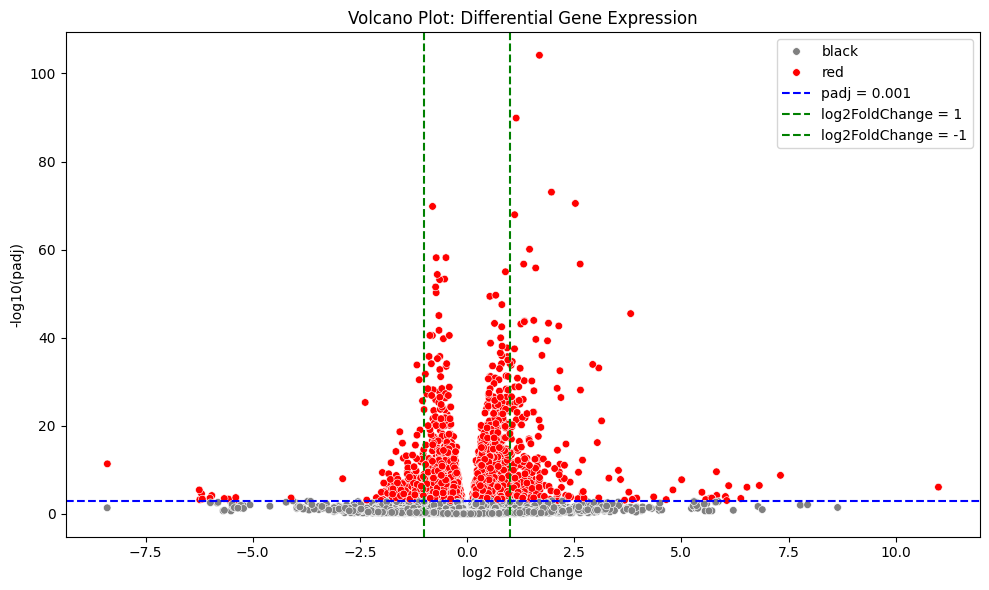

In [9]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='log2FoldChange', y='-log10(padj)', data=de_results, hue='color', palette={'red': 'red', 'black': 'gray'}, s=30)
plt.xlabel('log2 Fold Change')
plt.ylabel('-log10(padj)')
plt.title('Volcano Plot: Differential Gene Expression')

plt.axhline(y=-np.log10(0.001), color='blue', linestyle='--', label="padj = 0.001")
plt.axvline(x=1, color='green', linestyle='--', label="log2FoldChange = 1")
plt.axvline(x=-1, color='green', linestyle='--', label="log2FoldChange = -1")

plt.legend()

plt.tight_layout()
plt.show()

## Zadanie 4

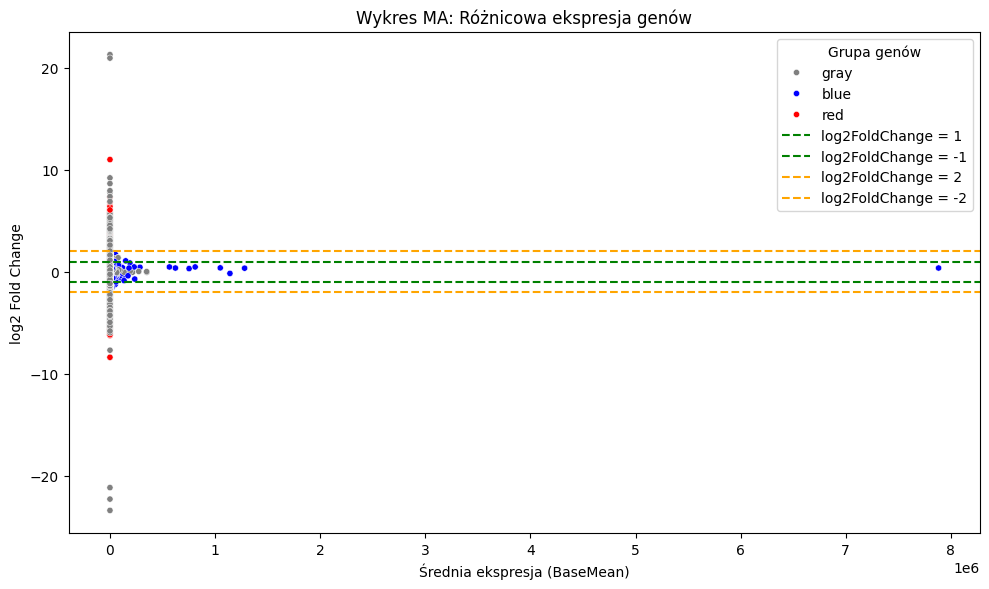

In [10]:
mean_expression = de_results[['baseMean']]

ma_plot_data = pd.DataFrame({
    'mean_expression': mean_expression['baseMean'],
    'log2FoldChange': de_results['log2FoldChange'],
    'padj': de_results['padj']
})

ma_plot_data['color'] = np.where((ma_plot_data['padj'] < 0.001) & (abs(ma_plot_data['log2FoldChange']) > 2), 'red',
                                 np.where((ma_plot_data['padj'] < 0.001), 'blue', 'gray'))

plt.figure(figsize=(10, 6))
sns.scatterplot(x='mean_expression', y='log2FoldChange', data=ma_plot_data, hue='color', palette={'red': 'red', 'blue': 'blue', 'gray': 'gray'}, s=20)

plt.axhline(y=1, color='green', linestyle='--', label="log2FoldChange = 1")
plt.axhline(y=-1, color='green', linestyle='--', label="log2FoldChange = -1")
plt.axhline(y=2, color='orange', linestyle='--', label="log2FoldChange = 2")
plt.axhline(y=-2, color='orange', linestyle='--', label="log2FoldChange = -2")

plt.xlabel('Średnia ekspresja (BaseMean)')
plt.ylabel('log2 Fold Change')
plt.title('Wykres MA: Różnicowa ekspresja genów')
plt.legend(title="Grupa genów", loc='upper right')

plt.tight_layout()
plt.show()

## Zadanie 5

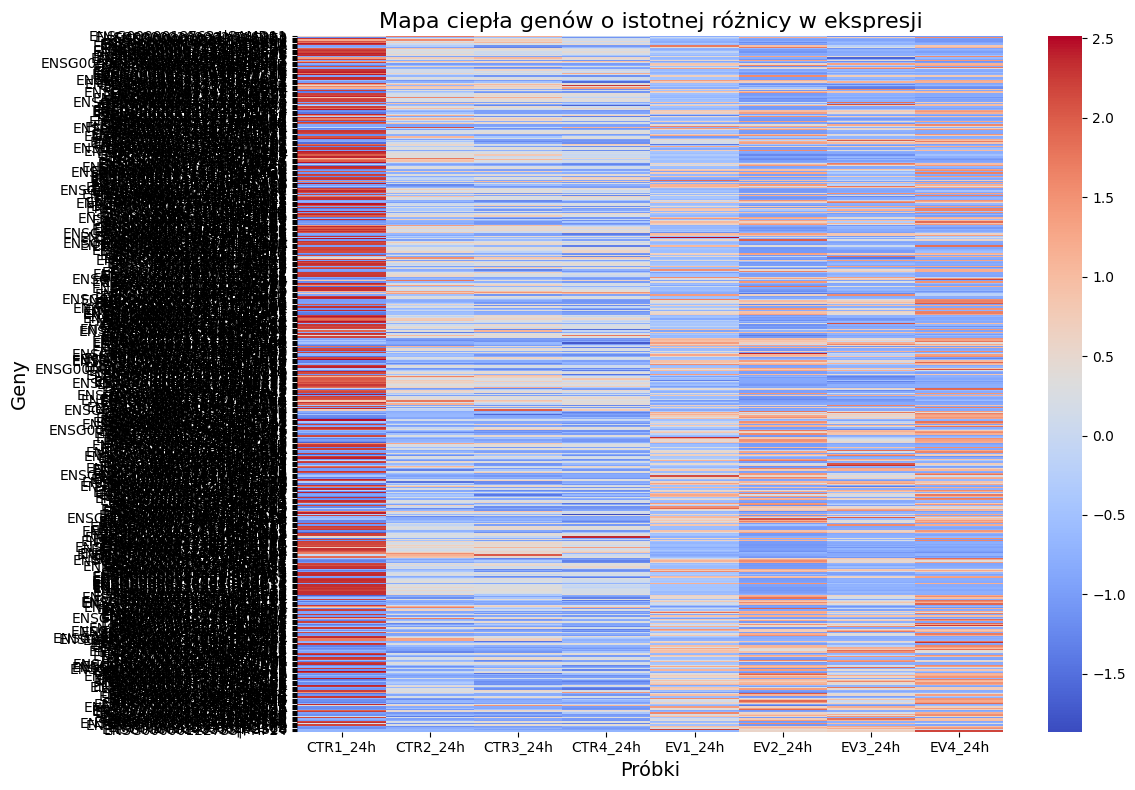

In [86]:
# Wczytanie wyników z analizy różnicowej ekspresji (plik CSV)
de_results = pd.read_csv("differential_expression_results.csv", index_col=0)

# Filtracja genów o istotnej różnicy w ekspresji
# Geny, które mają padj < 0.001 oraz |log2FoldChange| > 1
significant_genes = de_results[(de_results['padj'] < 0.001) & (abs(de_results['log2FoldChange']) > 1)]

# Przygotowanie danych ekspresji genów do wizualizacji
# Wczytujemy count_table (zakładając, że to znormalizowane dane z rlog lub TPM/FPKM)
count_table = pd.read_csv("new_data.csv", sep=";", index_col=0)

# Zastosowanie filtracji, żeby zostawić tylko geny, które są istotne
filtered_data = count_table.loc[significant_genes.index]

# Znormalizowanie danych - standaryzacja, aby każda próbka miała średnią 0 i odchylenie standardowe 1
scaler = StandardScaler()
normalized_data = scaler.fit_transform(filtered_data.T).T

# Stworzenie mapy ciepłej
plt.figure(figsize=(12, 8))
sns.heatmap(normalized_data, cmap="coolwarm", annot=False, fmt=".2f", xticklabels=count_table.columns, yticklabels=filtered_data.index)

# Dodanie tytułu i etykiet
plt.title("Mapa ciepła genów o istotnej różnicy w ekspresji", fontsize=16)
plt.xlabel("Próbki", fontsize=14)
plt.ylabel("Geny", fontsize=14)

# Pokaż wykres
plt.tight_layout()
plt.show()

                                         term_name     term_id  highlighted  \
source                                                                        
GO:MF          structural constituent of chromatin  GO:0030527         True   
GO:MF                          microtubule binding  GO:0008017         True   
GO:MF                              tubulin binding  GO:0015631        False   
GO:MF                              protein binding  GO:0005515        False   
GO:MF                                  ATP binding  GO:0005524         True   
GO:MF              carbohydrate derivative binding  GO:0097367        False   
GO:MF                       ATP-dependent activity  GO:0140657         True   
GO:MF                adenyl ribonucleotide binding  GO:0032559        False   
GO:MF        ATP-dependent activity, acting on DNA  GO:0008094        False   
GO:MF                    adenyl nucleotide binding  GO:0030554        False   
GO:MF   purine ribonucleoside triphosphate binding  

C:\Users\kacpe\AppData\Local\Temp\ipykernel_18332\3544389510.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


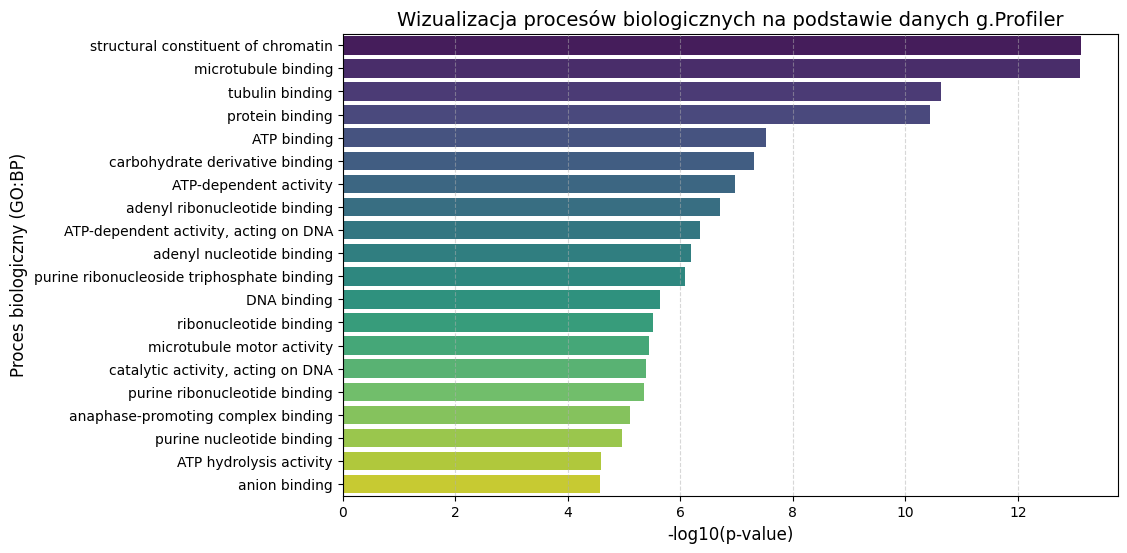

In [92]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 📌 Wczytaj plik CSV
g_profiler = pd.read_csv("gProfiler_hsapiens_30.01.2025_17-21-23__intersections.csv", sep=",", index_col=0, nrows=20)

# 📌 Sortowanie danych według wartości -log10(p_value)
g_profiler = g_profiler.sort_values(by="negative_log10_of_adjusted_p_value", ascending=False)

print(g_profiler) 

# 📌 Wykres kolumnowy (BarPlot)
plt.figure(figsize=(10, 6))
sns.barplot(
    data=g_profiler, 
    x="negative_log10_of_adjusted_p_value", 
    y="term_name", 
    palette="viridis"
)

# 📌 Stylizacja wykresu
plt.xlabel("-log10(p-value)", fontsize=12)
plt.ylabel("Proces biologiczny (GO:BP)", fontsize=12)
plt.title("Wizualizacja procesów biologicznych na podstawie danych g.Profiler", fontsize=14)
plt.grid(axis="x", linestyle="--", alpha=0.5)

# 📌 Wyświetlenie wykresu
plt.show()


C:\Users\kacpe\AppData\Local\Temp\ipykernel_18332\277582429.py:21: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  upset_data = gene_sets.pivot(index="genes", columns="term_name", values="present").fillna(False)
c:\users\kacpe\pycharmprojects\pf\venv\lib\site-packages\upsetplot\plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace 

term_name        ATP binding  ATP hydrolysis activity  ATP-dependent activity  \
genes                                                                           
ENSG00000004799         True                    False                   False   
ENSG00000005513        False                    False                   False   
ENSG00000006634        False                    False                   False   
ENSG00000007968        False                    False                   False   
ENSG00000008277        False                    False                   False   
...                      ...                      ...                     ...   
ENSG00000278463        False                    False                   False   
ENSG00000278588        False                    False                   False   
ENSG00000278677        False                    False                   False   
ENSG00000286235         True                     True                    True   
ENSG00000286522        False

<Figure size 1000x600 with 0 Axes>

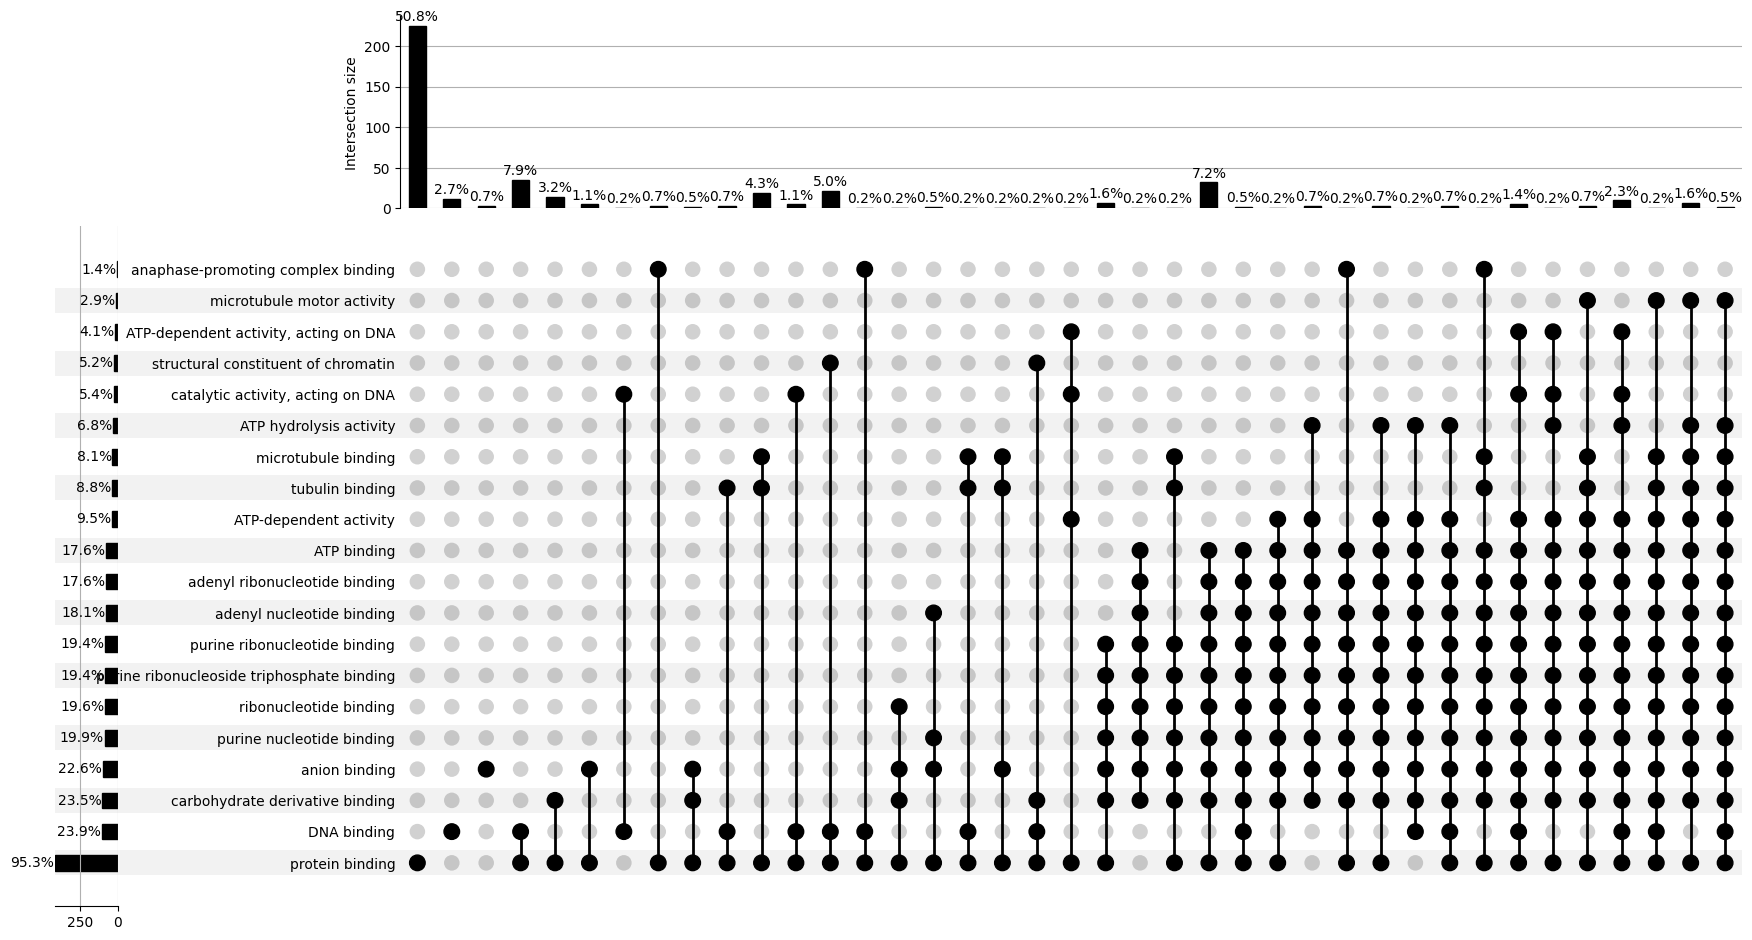

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
from upsetplot import UpSet, from_indicators

# 1. Wczytanie CSV
g_profiler = pd.read_csv("gProfiler_hsapiens_30.01.2025_17-21-23__intersections.csv", sep=",", index_col=0, nrows=20)

# 2. Rozbijanie kolumny "intersections" na listę genów
g_profiler["genes"] = g_profiler["intersections"].apply(lambda x: x.split(","))

# 3. Tworzenie "long table" (gene_sets)
gene_sets = g_profiler.explode("genes")[["term_name", "genes"]]

# 4. Dodajemy kolumnę 'present' = True
gene_sets["present"] = True

# 5. Usuwamy duplikaty (jeśli gene + term_name powtarzają się wiele razy)
gene_sets.drop_duplicates(subset=["genes", "term_name"], inplace=True)

# 6. Pivot -> szeroka tabela
upset_data = gene_sets.pivot(index="genes", columns="term_name", values="present").fillna(False)
print(upset_data)

# 7. Tworzenie wykresu UpSet
plt.figure(figsize=(10, 6))
upset = UpSet(
    from_indicators(upset_data.columns, upset_data),
    subset_size="count",
    show_percentages=True
)
upset.plot()

plt.show()


Input sequence provided is already in string format. No operation performed


Przekonwertowano 23 genów
Przykładowe mapowania: {'ENSG00000183598': 'hsa:653604', 'ENSG00000203811': 'hsa:126961', 'ENSG00000203852': 'hsa:333932', 'ENSG00000184270': 'hsa:317772', 'ENSG00000188486': 'hsa:3014', 'ENSG00000115163': 'hsa:1058', 'ENSG00000124610': 'hsa:3024', 'ENSG00000286522': 'hsa:8358', 'ENSG00000278463': 'hsa:8335', 'ENSG00000277224': 'hsa:8343', 'ENSG00000277775': 'hsa:8968', 'ENSG00000273983': 'hsa:8355', 'ENSG00000278588': 'hsa:8346', 'ENSG00000196787': 'hsa:8969', 'ENSG00000274997': 'hsa:85235', 'ENSG00000276368': 'hsa:8331', 'ENSG00000276903': 'hsa:8332', 'ENSG00000275221': 'hsa:8330', 'ENSG00000233822': 'hsa:8341', 'ENSG00000184357': 'hsa:3009', 'ENSG00000275126': 'hsa:8368', 'ENSG00000278677': 'hsa:8336', 'ENSG00000274641': 'hsa:8348'}
Znaleziono 3 genów z zestawu w szlaku path:hsa04613


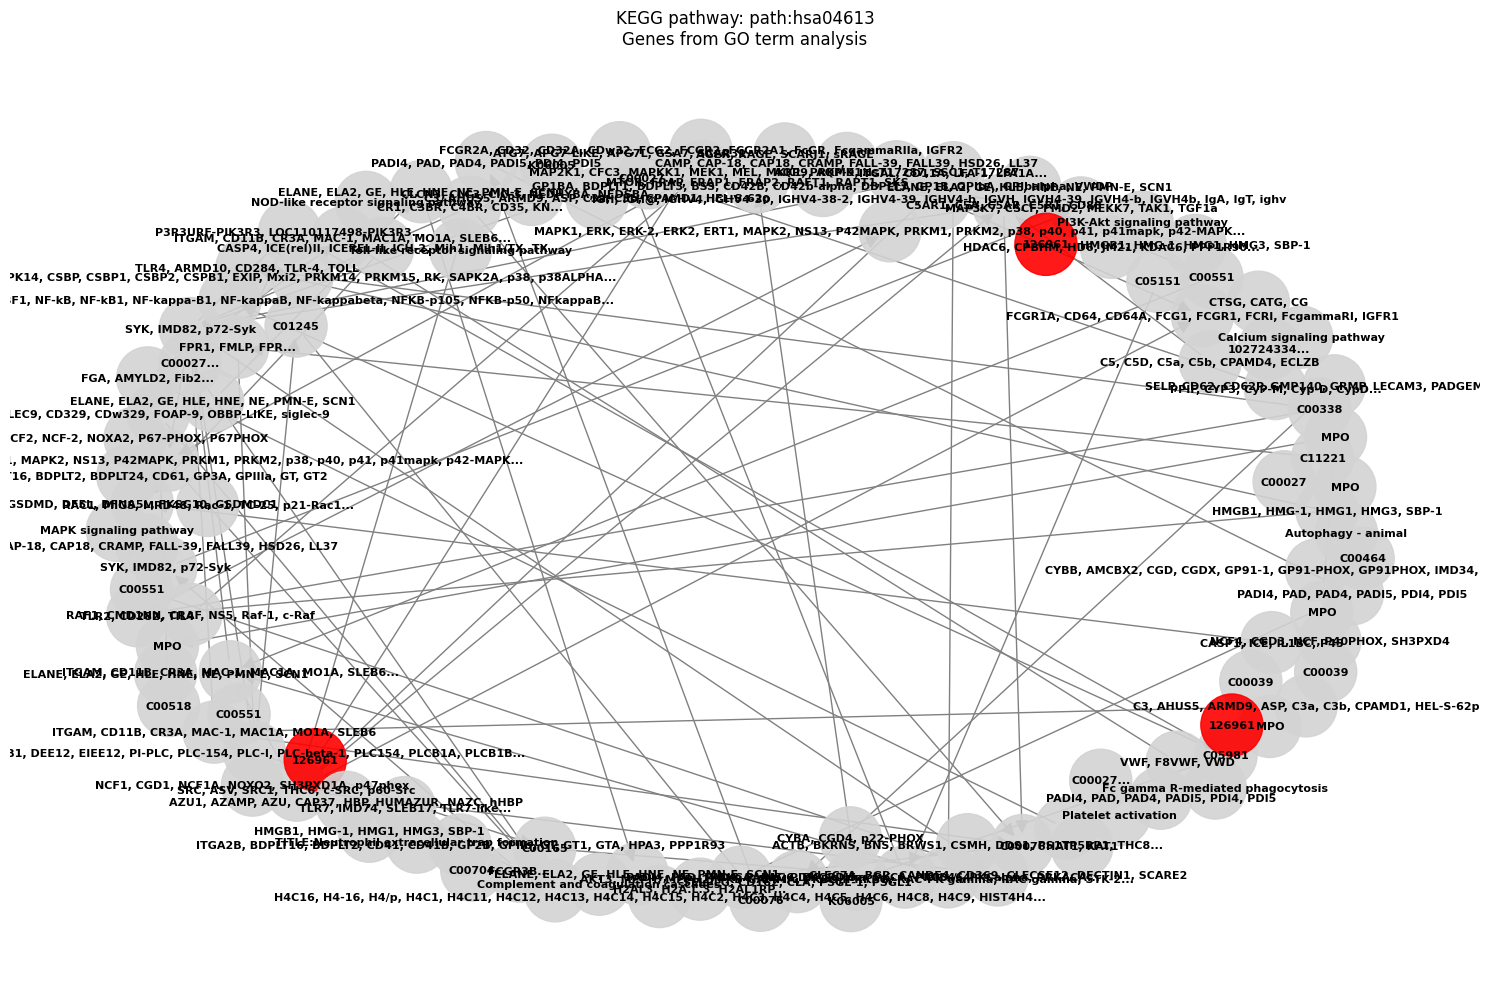

In [75]:
import os
import tempfile

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

from Bio.KEGG.KGML.KGML_parser import read
from Bio.KEGG.REST import kegg_get
import mygene


def convert_ensembl_to_kegg(ensembl_ids):
    """
    Konwertuje identyfikatory Ensembl (np. ENSG00000...) na identyfikatory KEGG (hsa:XXXX)
    używając bazy mygene.info (EntrezGene -> KEGG).
    """
    mg = mygene.MyGeneInfo()
    
    # Zapytanie do mygene, żeby uzyskać ID Entrez i symbol na podstawie Ensembl
    results = mg.querymany(
        ensembl_ids,
        scopes='ensembl.gene',
        fields=['entrezgene', 'symbol'],
        species='human'
    )
    
    # Tworzymy słownik mapowania Ensembl -> hsa:Entrez
    id_map = {}
    for result in results:
        if 'entrezgene' in result:
            ensembl = result['query']    # np. "ENSG00000183598"
            entrez = result['entrezgene']  # np. 653604
            id_map[ensembl] = f"hsa:{entrez}"
    
    return id_map


def process_go_data(csv_file):
    """
    1. Wczytuje dane GO z pliku CSV (pierwszy wiersz).
    2. Odczytuje kolumnę 'intersections' (lista Ensembl IDs).
    3. Konwertuje Ensembl -> KEGG (hsa:XXXX).
    4. Zwraca słownik expression_data (domyślnie = 1.0 dla każdego genu).
    """
    df = pd.read_csv(csv_file)
    
    genes_str = df.iloc[0]['intersections']  # np. "ENSG00000183598,ENSG00000203811,..."
    ensembl_genes = genes_str.split(',')
    
    # Konwertuj identyfikatory Ensembl -> KEGG
    id_map = convert_ensembl_to_kegg(ensembl_genes)
    
    # Tworzymy dict: { 'hsa:XXXX': 1.0, 'hsa:YYYY': 1.0, ... }
    expression_data = {kegg_id: 1.0 for kegg_id in id_map.values()}
    
    print(f"Przekonwertowano {len(expression_data)} genów")
    print("Przykładowe mapowania:", dict(list(id_map.items())))
    
    return expression_data


def visualize_pathway(pathway_id, expression_data):
    """
    1. Pobiera plik KGML (kegg_get(pathway_id, "kgml")).
    2. Zapisuje go do pliku tymczasowego.
    3. Parsuje przez BioPython (read).
    4. Tworzy graf w NetworkX i koloruje geny z expression_data na czerwono.
    5. Rysuje i wyświetla wynik.
    """
    # 1) Pobierz plik KGML
    kgml_data = kegg_get(pathway_id, "kgml")
    kgml_str = kgml_data.read()
    if not kgml_str or "Cannot find" in kgml_str or "Access denied" in kgml_str:
        print(f"Brak dostępu lub nie znaleziono szlaku: {pathway_id}")
        return
    
    # 2) Zapisz do pliku tymczasowego
    with tempfile.NamedTemporaryFile(mode='w', delete=False, suffix='.xml') as tmp:
        tmp.write(kgml_str)
        tmp_path = tmp.name

    try:
        # 3) Parsuj plik KGML
        with open(tmp_path, 'r') as f:
            pathway = read(f)
        
        # 4) Budowa grafu
        G = nx.DiGraph()
        
        # Dodawanie węzłów
        for entry in pathway.entries.values():
            if hasattr(entry, 'name'):
                names = entry.name.split()
                # Szukamy identyfikatorów hsa:XXXX
                gene_ids = [n for n in names if 'hsa:' in n]
                gene_id = gene_ids[0] if gene_ids else None
                
                G.add_node(
                    entry.id,
                    kegg_id=gene_id,
                    type=entry.type,
                    graphics=entry.graphics[0] if entry.graphics else None
                )

        # Dodawanie krawędzi
        for relation in pathway.relations:
            if hasattr(relation, 'entry1') and hasattr(relation, 'entry2'):
                G.add_edge(
                    relation.entry1.id,
                    relation.entry2.id,
                    type=relation.type
                )

        # 5) Kolorowanie i etykiety
        node_colors = []
        node_labels = {}
        
        matching_genes = 0
        
        for node in G.nodes():
            node_data = G.nodes[node]
            kid = node_data.get('kegg_id')  # np. "hsa:653604"
            graphics = node_data.get('graphics')
            
            if kid and kid in expression_data:
                # Gen jest w zestawie -> kolor czerwony
                color = 'red'
                label = kid.replace('hsa:', '')  # np. "653604"
                matching_genes += 1
            else:
                color = 'lightgray'
                # Etykieta: nazwa z graphics, jeśli istnieje
                label = graphics.name if graphics and hasattr(graphics, 'name') else ''
            
            node_colors.append(color)
            node_labels[node] = label

        print(f"Znaleziono {matching_genes} genów z zestawu w szlaku {pathway_id}")

        # 6) Rysowanie grafu
        plt.figure(figsize=(15, 10))
        pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
        
        nx.draw_networkx_nodes(
            G, pos,
            node_color=node_colors,
            node_size=2000,
            alpha=0.9
        )
        
        nx.draw_networkx_edges(
            G, pos,
            edge_color='gray',
            arrows=True,
            arrowsize=20
        )
        
        nx.draw_networkx_labels(
            G, pos,
            labels=node_labels,
            font_size=8,
            font_weight='bold'
        )
        
        plt.title(f"KEGG pathway: {pathway_id}\nGenes from GO term analysis", pad=20)
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
    finally:
        # Usunięcie pliku tymczasowego
        os.unlink(tmp_path)


# ============ PRZYKŁAD UŻYCIA ============

# 1) Wczytanie i przetworzenie danych GO z pliku CSV:
expression_data = process_go_data('gProfiler_hsapiens_30.01.2025_17-21-23__intersections.csv')

# 2) Wizualizacja wybranego szlaku. 
#    Upewnij się, że geny faktycznie są w tym szlaku. 
#    np. "path:hsa04613" => Ras signaling pathway itp.
#    Zmień w zależności od tego, w którym szlaku KEGG występują Twoje geny.
visualize_pathway("path:hsa04613", expression_data)



term_name
binding                                          469
protein binding                                  422
biological regulation                            354
regulation of biological process                 346
regulation of cellular process                   327
Factor: Lhx8; motif: TGATTG                      286
response to stimulus                             272
nucleus                                          271
cellular component organization or biogenesis    259
cellular component organization                  258
Name: intersection_size, dtype: int64


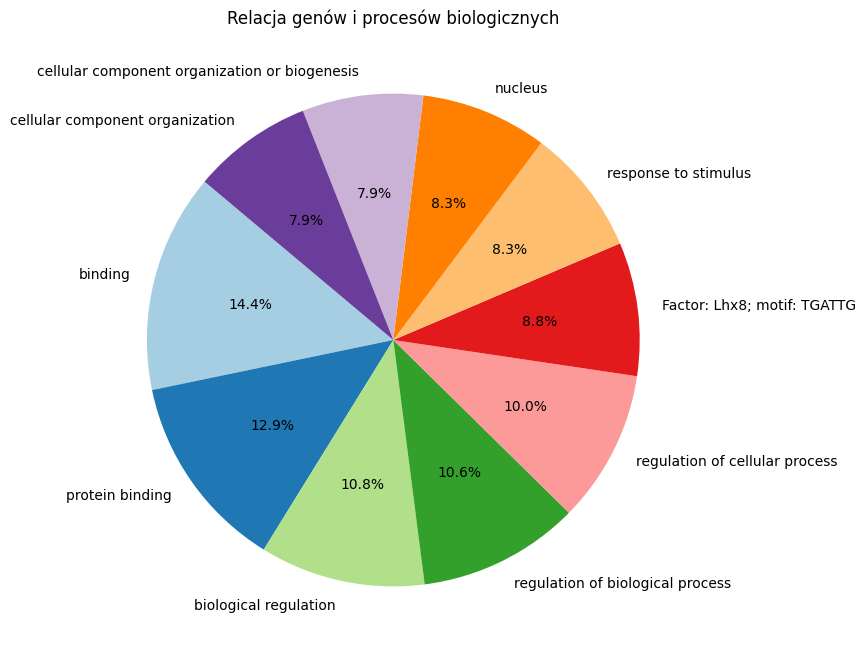

In [89]:
import pandas as pd
import matplotlib.pyplot as plt

# 📌 Wczytanie danych gProfiler
g_profiler = pd.read_csv("gProfiler_hsapiens_30.01.2025_17-21-23__intersections.csv", sep=",", index_col=0)

# 📌 Liczba genów w każdym procesie biologicznym (intersection_size)
process_counts = g_profiler.groupby("term_name")["intersection_size"].sum().sort_values(ascending=False)

# 📌 Wybór tylko Top 10 procesów dla przejrzystości wykresu
top_processes = process_counts.head(10)
print(top_processes)

# 📌 Wykres kołowy
plt.figure(figsize=(8, 8))
plt.pie(top_processes, labels=top_processes.index, autopct="%1.1f%%", startangle=140, colors=plt.cm.Paired.colors)
plt.title("Relacja genów i procesów biologicznych")
plt.show()
